# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directory: {BASE_DIR}")



Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [2]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    - For majority files (samples > 1 or filename contains 'majority'), look for a line
      containing 'Pass@' and take the first float after the colon.
    - Otherwise, look for the last dict line containing the dataset_key.
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        for line in text:
            if "Pass@" in line:
                # Expect formats like: "Pass@32 (Any Correct):            0.6884 (68.84%)"
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
                # Fallback: grab first float on the line
                import re as _re
                match = _re.search(r"([0-9]*\.?[0-9]+)", line)
                if match:
                    try:
                        return float(match.group(1))
                    except Exception:
                        pass
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Pre-train collection
    pre_match = pre_pattern.match(name)
    if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
        samples = int(pre_match.group("samples"))
        result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
        score = read_score(path / result_file, samples=samples)
        pretrain_rows.append(
            {
                "step": int(pre_match.group("step")),
                "shot": int(pre_match.group("shot")),
                "samples": samples,
                "temp": float(pre_match.group("temp")),
                "score": score,
                "path": str(path),
            }
        )
        continue

    # RL collection (first pattern that matches wins)
    matched = False
    for pat in rl_patterns:
        rl_match = pat.match(name)
        if rl_match:
            samples = int(rl_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(rl_match.group("pt_step"))
            rl_step = int(rl_match.group("rl_step"))
            num_rollouts = int(rl_match.group("num_rollouts")) if "num_rollouts" in rl_match.groupdict() else 5
            rl_rows.append(
                {
                    "pt_step": pt_step,
                    "rl_step": rl_step,
                    "total_step": pt_step + rl_step,
                    "samples": samples,
                    "temp": float(rl_match.group("temp")),
                    "num_rollouts": num_rollouts,
                    "score": score,
                    "path": str(path),
                    "label": name,
                }
            )
            matched = True
            break
    if matched:
        continue

    # SFT collection (first pattern that matches wins)
    for pat in sft_patterns:
        sft_match = pat.match(name)
        if sft_match:
            samples = int(sft_match.group("samples"))
            shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(sft_match.group("pt_step"))
            sft_step = int(sft_match.group("sft_step"))
            if "5epoch" in name:
                epochs = 5
            else:
                epochs = 1
            sft_rows.append(
                {
                    "pt_step": pt_step,
                    "sft_step": sft_step,
                    "total_step": pt_step + sft_step,
                    "shot": shot,
                    "samples": samples,
                    "temp": float(sft_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                    "sft_epochs": epochs,
                }
            )
            break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

Loaded 139 pre-train runs, 106 RL runs, 63 SFT runs.


In [3]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp", "num_rollouts"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,0,1,0.6,0.015163,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,0.081100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,0.196400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,0.379100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
76,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
77,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
74,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
75,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,num_rollouts,score,path,label
22,1000,400,1400,1,0.6,32,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
24,1000,400,1400,8,0.6,32,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
23,1000,400,1400,32,0.6,32,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
25,1000,800,1800,1,0.6,32,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step800-rl-0sho...
27,1000,800,1800,8,0.6,32,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step800-rl-0sho...
...,...,...,...,...,...,...,...,...,...
50,22000,800,22800,32,0.6,5,0.799800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...
60,22000,800,22800,32,0.6,5,0.812000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n5-step800-rl-0sho...
56,22000,800,22800,32,0.6,32,0.821800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step800-rl-0sh...
48,22000,800,22800,128,0.6,5,0.878700,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
33,3000,285,3285,0,1,0.0,0.122820,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
35,3000,285,3285,0,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
34,3000,285,3285,0,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
32,3000,285,3285,0,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
28,3000,1389,4389,0,1,0.0,0.238817,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
...,...,...,...,...,...,...,...,...,...,...
19,22000,1389,23389,0,1,0.0,0.463230,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
20,22000,1389,23389,0,1,0.6,0.413950,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
22,22000,1389,23389,0,8,0.6,0.740700,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
21,22000,1389,23389,0,32,0.6,0.865800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5


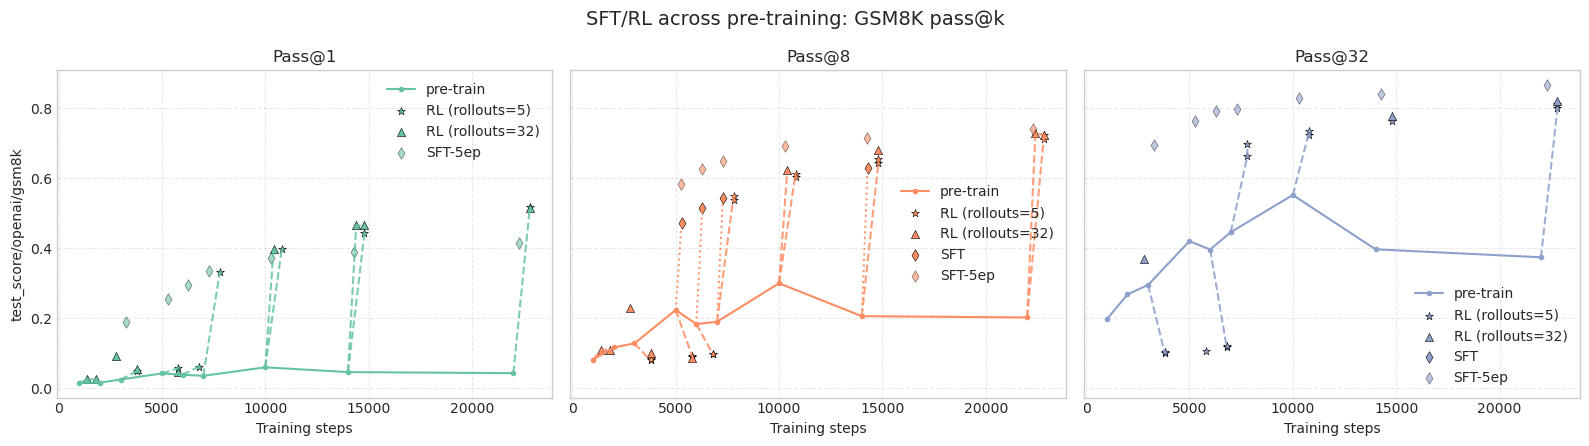

In [9]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 0
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4.5 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL: plot different curves for each num_rollouts
        rl_all = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["num_rollouts", "pt_step", "rl_step"])
        unique_num_rollouts = sorted(rl_all["num_rollouts"].dropna().unique())
        # from matplotlib.cm import get_cmap
        # rl_cmap = get_cmap("tab10")
        for j, num_rollouts in enumerate(unique_num_rollouts):
            # subcolor = rl_cmap(j % rl_cmap.N)
            subset = rl_all[rl_all["num_rollouts"] == num_rollouts]
            rl_labeled = False
            for pt_step, group in subset.groupby("pt_step"):
                pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
                start_score = pre_match.iloc[0] if not pre_match.empty else None
                group_sorted = group.sort_values("rl_step")
                xs = [pt_step] if start_score is not None else []
                ys = [start_score] if start_score is not None else []
                xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                ys.extend(group_sorted["score"].tolist())
                if not xs:
                    continue
                label_rl = f"RL (rollouts={num_rollouts})" if not rl_labeled else None
                ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.85)
                if len(xs) > 1:
                    ax.scatter(xs[1:], ys[1:], marker="*" if num_rollouts == 5 else "^", color=color, s=35, edgecolor="k", linewidth=0.4, label=label_rl)
                    rl_labeled = True

        # SFT standard
        sft_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 1) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft_labeled = False
        for pt_step, group in sft_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
                sft_labeled = True

        # SFT 5-epoch
        sft5_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 5) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft5_labeled = False
        for pt_step, group in sft5_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//5) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-5ep" if not sft5_labeled else None, alpha=0.6)
                sft5_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: GSM8K pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()



In [5]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [6]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.015163,NaN,0.025019,0.0811,NaN,0.1092,0.1964,NaN,NaN,0.3791,NaN,NaN
1,2000,0.015163,NaN,0.090978,0.1160,NaN,0.2290,0.2676,NaN,0.3692,NaN,NaN,NaN
2,3000,0.024261,0.188021,0.053829,0.1274,NaN,0.0788,0.2949,0.6945,0.1001,NaN,0.8605,0.1084
3,5000,0.041698,0.255497,0.046247,0.2229,0.5838,0.0910,0.4200,0.7627,NaN,NaN,0.8893,0.1130
4,6000,0.037908,0.295679,0.061410,0.1827,0.6262,0.0963,0.3958,0.7923,0.1168,NaN,0.9052,0.1243
5,7000,0.034875,0.334344,0.330553,0.1895,0.6490,0.5497,0.4458,0.7991,0.6634,0.6854,0.9052,0.7945
6,10000,0.059136,0.370735,NaN,0.2995,0.6914,0.6133,0.5519,0.8279,0.7354,NaN,0.9181,0.8249
7,14000,0.045489,0.389689,0.464746,0.2055,0.7149,0.6422,0.3965,0.8393,NaN,0.5679,0.9265,0.8317
8,22000,0.042456,0.413950,0.514026,0.2017,0.7407,0.7134,0.3738,0.8658,0.7998,NaN,0.9272,0.8787


In [ ]:
# Example usage: Compare a pre-train checkpoint with an RL checkpoint
# Uncomment and modify the paths below to run the comparison

# before_path = "/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results/1B-step14000-1shot-8samples-temp0.6/math_predictions.parquet"
# after_path = "/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny_tmp/olmo2_1b_step14000_omi_n64-step400-rl-0shot-boxed-8samples-temp0.6/math_predictions.parquet"

# compare_math_results(
#     before_path=before_path,
#     after_path=after_path,
#     k=8,  # Pass@8 evaluation
#     max_display=20  # Show up to 20 improved questions
# )

# Inspect and Compare MATH Results

This section compares two model checkpoints on the MATH dataset to identify questions where the "after" model improves over the "before" model in a Pass@k setting.

For each question, we check:
1. Does the "before" model fail (all k samples incorrect)?
2. Does the "after" model succeed (at least one of k samples correct)?

If both are true, we display all correct generations from the "after" model.

In [ ]:
import numpy as np
from verl.utils.reward_score.math_reward import compute_score as math_compute_score


def compare_math_results(before_path, after_path, k=8, max_display=20):
    """
    Compare two MATH prediction files and identify improvements.
    
    Args:
        before_path: Path to the "before" model's predictions parquet file
        after_path: Path to the "after" model's predictions parquet file
        k: Number of samples for Pass@k evaluation
        max_display: Maximum number of improved questions to display
    """
    print("=" * 100)
    print(f"MATH COMPARISON: Pass@{k}")
    print("=" * 100)
    print(f"Before: {before_path}")
    print(f"After:  {after_path}")
    print()
    
    # Load predictions
    before_df = pd.read_parquet(before_path)
    after_df = pd.read_parquet(after_path)
    
    print(f"Before samples: {len(before_df)}")
    print(f"After samples:  {len(after_df)}")
    print()
    
    # Track improvements
    improvements = []
    
    # Iterate through questions (assuming both have same questions in same order)
    for idx in range(min(len(before_df), len(after_df))):
        before_row = before_df.iloc[idx]
        after_row = after_df.iloc[idx]
        
        # Get ground truth
        ground_truth = before_row['reward_model']['ground_truth']
        
        # Get responses
        before_responses = before_row['responses'] if isinstance(before_row['responses'], (list, np.ndarray)) else [before_row['responses']]
        after_responses = after_row['responses'] if isinstance(after_row['responses'], (list, np.ndarray)) else [after_row['responses']]
        
        # Ensure we have k samples
        before_responses = before_responses[:k]
        after_responses = after_responses[:k]
        
        # Compute scores for before model
        before_scores = [math_compute_score(resp, ground_truth) for resp in before_responses]
        before_pass = any(score > 0 for score in before_scores)
        
        # Compute scores for after model
        after_scores = [math_compute_score(resp, ground_truth) for resp in after_responses]
        after_pass = any(score > 0 for score in after_scores)
        
        # Check if this is an improvement (before failed, after succeeded)
        if not before_pass and after_pass:
            # Find all correct responses from after model
            correct_responses = [resp for resp, score in zip(after_responses, after_scores) if score > 0]
            
            improvements.append({
                'idx': idx,
                'row': after_row,
                'ground_truth': ground_truth,
                'correct_responses': correct_responses,
                'num_correct': len(correct_responses),
            })
    
    # Summary
    print(f"Total questions: {min(len(before_df), len(after_df))}")
    print(f"Improvements (before fail → after success): {len(improvements)}")
    print()
    
    if len(improvements) == 0:
        print("No improvements found!")
        return
    
    # Display improved questions
    num_to_display = min(max_display, len(improvements))
    print("=" * 100)
    print(f"DISPLAYING {num_to_display} IMPROVED QUESTIONS")
    print("=" * 100)
    
    for i, improvement in enumerate(improvements[:num_to_display], 1):
        row = improvement['row']
        
        print()
        print("-" * 100)
        print(f"IMPROVED QUESTION {i}/{num_to_display} (Index: {improvement['idx']})")
        print("-" * 100)
        
        # Extract question from prompt
        prompt = row['prompt']
        if isinstance(prompt, (list, np.ndarray)):
            question = None
            for msg in prompt:
                if isinstance(msg, dict) and msg.get('role') == 'user':
                    question = msg.get('content', '')
            if question:
                print(f"\nQuestion:\n{question}")
        
        print(f"\nType: {row['type']}")
        print(f"Level: {row['level']}")
        print(f"\nGround Truth: {improvement['ground_truth']}")
        print(f"\nNumber of correct responses (out of {k}): {improvement['num_correct']}")
        
        # Display all correct responses
        for j, correct_resp in enumerate(improvement['correct_responses'], 1):
            print(f"\n{'~' * 80}")
            print(f"Correct Response {j}/{improvement['num_correct']}:")
            print(f"{'~' * 80}")
            print(correct_resp)
    
    print()
    print("=" * 100)
    print(f"Summary: {len(improvements)} total improvements found")
    print("=" * 100)